In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import antropy as ant
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks, correlate
from scipy.signal import butter, filtfilt

In [6]:
def compute_mmd(epoch, window_size = 50, step_size = 25):
    mmd = 0
    for start in range(0, len(epoch) - window_size, step_size):
        window = epoch[start:start + window_size]

        max_idx = np.argmax(window)
        min_idx = np.argmin(window)

        delta_x = max_idx - min_idx
        delta_y = window[max_idx] - window[min_idx]

        distance = np.sqrt(delta_x ** 2 + delta_y ** 2)
        mmd += distance
    return mmd
def compute_esis(epoch, fs):
    
    energy = np.square(epoch)
    slope = np.abs(np.diff(epoch, prepend=epoch[0]))
    v = fs * slope
    esis = np.sum(energy * v)
    return esis
def hjorth_parameters(epoch):
    first_deriv = np.diff(epoch)
    second_deriv = np.diff(first_deriv)

    var_zero = np.var(epoch)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)

    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility

    return complexity

bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 45)
}

def bandpower(sig, fs, band):  #filtrira signale po frekvencijama
    low, high = band
    b, a = butter(4, [low / (fs / 2), high / (fs / 2)], btype='band')
    filtered = filtfilt(b, a, sig)
    power = np.sum(filtered ** 2) / len(filtered)
    return power 

In [8]:
def compute_features(epoch):
    mmd = compute_mmd(epoch)
    zcr = ((epoch[:-1] * epoch[1:]) < 0).sum()
    esis = compute_esis(epoch, 100)
    ptp = np.mean(np.ptp(epoch))
    hj_complexity = hjorth_parameters(epoch)
    waves = {name: bandpower(epoch, 100, band) for name, band in bands.items()}
    return [mmd, zcr, esis, ptp, hj_complexity, waves['alpha'], waves['gamma'], waves['theta']]

In [ ]:


def compute_eog_features(e1_epoch, e2_epoch):
    # 1. EOG Differential Signal (E1 - E2)
    eog_diff = e1_epoch - e2_epoch
    diff_var = np.var(eog_diff)

    # 2. Zero Crossing Rate (ZCR) - individual channels
    zcr_e1 = ((e1_epoch[:-1] * e1_epoch[1:]) < 0).sum()

    # 3. Blink / Peak Count - individual channels
    peaks_e1, _ = find_peaks(np.abs(e1_epoch), height=np.std(e1_epoch))
    peaks_e2, _ = find_peaks(np.abs(e2_epoch), height=np.std(e2_epoch))
    peak_count_e1 = len(peaks_e1)

    # 4. Cross-Correlation between E1 and E2
    corr = correlate(e1_epoch, e2_epoch, mode='full')
    lags = np.arange(-len(e1_epoch)+1, len(e1_epoch))
    lag_at_max = lags[np.argmax(np.abs(corr))]

    return [
        diff_var,       # EOG Variance
        zcr_e1,         # ZCR E1
        peak_count_e1,  # Peaks E1
        lag_at_max      # Lag at max corr
    ]

In [37]:
folder = "C:/Analiza Faza Sna/Dataset"
files = [f for f in os.listdir(folder) if f.endswith(".csv")]


fs = 100
samples_per_epoch = fs * 30

all_subjects = []

for file in files[:5]:
    df = pd.read_csv(os.path.join(folder, file))
    df = df[(df["Sleep_Stage"] != 'P') & (df["Sleep_Stage"] != 'Missing')].copy()

    F4 = df["F4-M1"].values
    C4 = df["C4-M1"].values
    O2 = df["O2-M1"].values
    Fp1 = df["Fp1-O2"].values
    E1 = df["E1"].values
    E2 = df["E2"].values
    labels = df["Sleep_Stage"].values
    num_epochs = len(E1) // samples_per_epoch
    F4_epochs = np.array_split(F4[:num_epochs * samples_per_epoch], num_epochs)
    O2_epochs = np.array_split(O2[:num_epochs * samples_per_epoch], num_epochs)
    C4_epochs = np.array_split(C4[:num_epochs * samples_per_epoch], num_epochs)
    Fp1_epochs = np.array_split(Fp1[:num_epochs * samples_per_epoch], num_epochs)
    E1_epochs = np.array_split(E1[:num_epochs * samples_per_epoch], num_epochs)
    E2_epochs = np.array_split(E2[:num_epochs * samples_per_epoch], num_epochs)
    label_epochs = np.array_split(labels[:num_epochs * samples_per_epoch], num_epochs)

    features = []

    for f4, c4, o2, fp1, e1, e2, label_epoch in zip(F4_epochs, C4_epochs, O2_epochs, Fp1_epochs, E1_epochs, E2_epochs, label_epochs):
        F4_features = compute_features(f4)
        C4_features = compute_features(c4)
        O2_features = compute_features(o2)
        Fp1_features = compute_features(fp1)
        E_features = compute_eog_features(e1, e2)

        combined = np.concatenate([F4_features, E_features, C4_features, O2_features, Fp1_features])
        features.append(combined)

    epoch_labels = [pd.Series(epoch).mode()[0] for epoch in label_epochs]
                        
    all_subjects.append((np.array(features), np.array(epoch_labels)))


In [38]:
X = np.vstack([subject[0] for subject in all_subjects])
y = np.hstack([subject[1] for subject in all_subjects])  

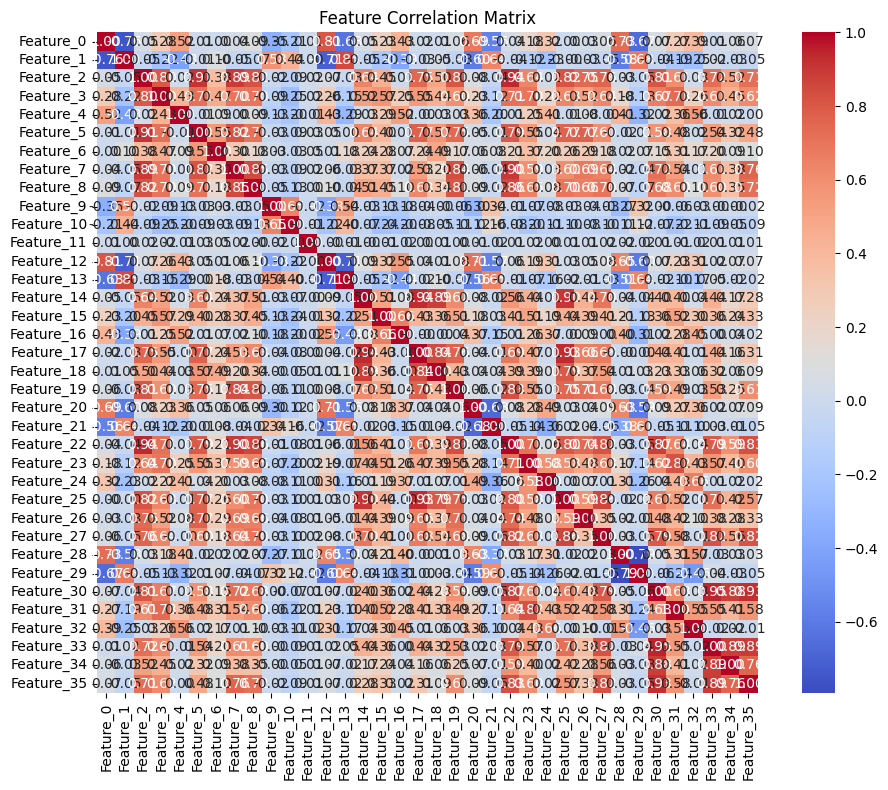

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35
Feature_0,1.000000,-0.756843,0.048370,0.279310,0.519293,0.010111,0.001059,0.040260,0.090181,-0.348532,...,0.027154,0.062249,0.733786,-0.666377,0.066930,0.272600,0.385545,0.005425,0.059039,0.067738
Feature_1,-0.756843,1.000000,-0.046951,-0.222196,-0.425491,-0.014723,0.099296,-0.048004,-0.072419,0.584360,...,-0.032767,-0.046713,-0.584857,0.678796,-0.044638,-0.190197,-0.245085,0.022985,-0.034917,-0.047027
Feature_2,0.048370,-0.046951,1.000000,0.799502,0.015097,0.911397,0.380741,0.893567,0.821206,-0.017131,...,0.746460,0.756992,0.030049,-0.051755,0.805865,0.607248,0.026059,0.721017,0.520940,0.714657
Feature_3,0.279310,-0.222196,0.799502,1.000000,0.426540,0.714313,0.474350,0.699049,0.700152,-0.093809,...,0.520564,0.636823,0.175484,-0.134658,0.669561,0.734854,0.255075,0.614474,0.451867,0.619977
Feature_4,0.519293,-0.425491,0.015097,0.426540,1.000000,-0.010899,0.093389,0.000964,0.094052,-0.127842,...,0.080442,-0.004996,0.412281,-0.322608,0.024994,0.363202,0.562953,-0.008886,0.023837,0.004654
Feature_5,0.010111,-0.014723,0.911397,0.714313,-0.010899,1.000000,0.554047,0.816669,0.710861,-0.032280,...,0.774036,0.604123,-0.015639,0.012163,0.584056,0.484519,0.018998,0.539008,0.319834,0.482533
Feature_6,0.001059,0.099296,0.380741,0.474350,0.093389,0.554047,1.000000,0.301138,0.178635,0.026616,...,0.289031,0.181083,0.022335,0.066028,0.147301,0.307279,0.171268,0.197441,0.093504,0.102306
Feature_7,0.040260,-0.048004,0.893567,0.699049,0.000964,0.816669,0.301138,1.000000,0.850794,-0.030081,...,0.686653,0.644277,0.016025,-0.037684,0.717757,0.540389,0.010425,0.609411,0.383208,0.761814
Feature_8,0.090181,-0.072419,0.821206,0.700152,0.094052,0.710861,0.178635,0.850794,1.000000,-0.050976,...,0.658035,0.699373,0.073039,-0.073073,0.679573,0.601970,0.101315,0.599940,0.348822,0.716281
Feature_9,-0.348532,0.584360,-0.017131,-0.093809,-0.127842,-0.032280,0.026616,-0.030081,-0.050976,1.000000,...,-0.036670,-0.028915,-0.274088,0.324534,0.001130,-0.060894,-0.031446,-0.002887,-0.001403,-0.015304


In [40]:
feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
df_features = pd.DataFrame(X, columns=feature_names)

corr_matrix = df_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

corr_matrix

In [41]:
mask = ~np.isnan(X).any(axis=1)

X = X[mask]
y = y[mask]

full_df = pd.DataFrame(X)   
full_df['Sleep_Stage'] = y
full_df.to_csv("35_featurea.csv")


In [24]:
print(X.shape)

(236411, 12)
